In [1]:
import os
import glob
import re
import datetime
from datetime import date, time, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from functools import partial
import torch

sns.set()

In [2]:
def parse_transcript(path):
    meeting_id = int(os.path.basename(os.path.dirname(path)))
    file_name = os.path.basename(path)
    file = re.search(r'^(?P<file>[A-Za-z0-9\-]+)_.*.vtt$', file_name).group('file')
    with open(path, 'r') as fh:
        while True:
            try:
                # ID
                m = None
                while m is None:
                    line = next(fh)
                    m = re.search(r'^(?P<id>\d+)\n?$', line)
                record = {'meeting_id': meeting_id, 'file': file, 'id': int(m.group('id'))}

                # Speak time details
                line = next(fh)
                m = re.search(r'^(?P<start>\d{2}:\d{2}:\d{2}.\d{3})\s+-+>\s+(?P<stop>\d{2}:\d{2}:\d{2}.\d{3})\n?$',
                              line)
                start = m.group('start')
                stop = m.group('stop')
                diff = datetime.datetime.strptime(stop, '%H:%M:%S.%f') - datetime.datetime.strptime(start, '%H:%M:%S.%f')
                spk_time = diff.total_seconds()
                record.update({'start': m.group('start'), 'stop': m.group('stop'), 'speak_time': spk_time})

                # Speaker and spoken word details
                line = next(fh)
                m = re.search(r'^((?P<speaker>[\w \t]+):)?(?P<text>.*)\n$', line)
                spkr = m.group('speaker')
                text = m.group('text')
                num_words = len([word for word in re.split(r'[\s\.,;]', m.group('text')) if word != ''])
                record.update({'speaker': spkr, 'text': text, 'num_words': num_words})

                yield record
            except StopIteration:
                break

In [3]:
def parse_participants(path):
    meeting_id = int(os.path.basename(os.path.dirname(path)))
    file_name = os.path.basename(path)
    file = re.search(r'^(?P<file>[\w\-]+).csv$', file_name).group('file')
    
    # Check if file has a related transcript
    # If not, don't parse
    transcript_filter = filter(lambda x: x.endswith('transcript.vtt'), os.listdir(os.path.dirname(path)))
    if len(list(transcript_filter)) > 0:
        with open(path, 'r') as fh:
            # Find where participant list starts
            line = None
            while line != '\n':
                line = next(fh)

            # Burn column row
            next(fh)

            # Get names (assumes name is first column for now)
            line = next(fh)
            while line != '\n':
                try:
                    name = line.split(',')[0]
                    yield {'meeting_id': meeting_id, 'file': file, 'participant': name}
                    line = next(fh)
                except StopIteration:
                    break

# Load Participants

In [63]:
ppaths = glob.glob('**/participants_*.csv', recursive=True)
ppaths

['zoom_data/83512718053/participants_83512718053.csv']

In [64]:
pchn = chain(*[parse_participants(pth) for pth in ppaths])
pdf = pd.DataFrame(pchn)
pdf

,meeting_id,file,participant
0,83512718053,participants_83512718053,Jack Cannon
1,83512718053,participants_83512718053,JoAnna Langberg


# Load Transcripts

In [65]:
paths = glob.glob('**/*.transcript.vtt', recursive=True)
paths

['zoom_data/83512718053/GMT20210527-002121_Recording.transcript.vtt']

In [66]:
chn = chain(*[parse_transcript(pth) for pth in paths])
df = pd.DataFrame(chn)
#df
df.drop(columns='file')

,meeting_id,id,start,stop,speak_time,speaker,text,num_words
0,83512718053,1,00:00:00.299,00:00:00.930,0.631,Jack Cannon,Here we go.,3
1,83512718053,2,00:00:09.690,00:00:10.290,0.600,Jack Cannon,One second.,2
2,83512718053,3,00:00:13.320,00:00:16.350,3.030,Jack Cannon,"When I did my presentation, the other day.",8
3,83512718053,4,00:00:17.789,00:00:20.280,2.491,Jack Cannon,I got to hit the share button.,7
4,83512718053,5,00:00:22.080,00:00:24.990,2.910,Jack Cannon,it's like you click share and then your monit...,11
...,...,...,...,...,...,...,...,...
281,83512718053,282,00:42:01.980,00:42:03.330,1.350,Jack Cannon,lot of material.,3
282,83512718053,283,00:42:04.860,00:42:06.210,1.350,Jack Cannon,For this next data set.,5
283,83512718053,284,00:42:09.420,00:42:10.890,1.470,Jack Cannon,So i'm going to stop sharing.,6
284,83512718053,285,00:42:13.530,00:42:14.400,0.870,JoAnna Langberg,or stop recording.,3


# Assign windows

In [67]:
def date_range(row):
    base = datetime.datetime.combine(date.today(), time.fromisoformat('00:00:00'))
    s = datetime.datetime.combine(date.today(), time.fromisoformat(row.start))
    e = datetime.datetime.combine(date.today(), time.fromisoformat(row.stop))
    exploded = pd.date_range(s, e, freq='S').union([e])
    tot_sec = (exploded - base).total_seconds()

    return tot_sec.to_numpy()

In [68]:
window_len = 300
df2 = df.loc[:, ['meeting_id', 'file', 'id', 'start', 'stop']]
df2['elapsed'] = df2.apply(date_range, axis=1)
df2 = df2.explode('elapsed')
df2['window'] = (df2.elapsed // window_len + 1).astype(int) * window_len
df2['window_time'] = df2.groupby(['meeting_id', 'file', 'id', 'window']).elapsed.diff()
df2.dropna(inplace=True)
df2 = df2.groupby(['meeting_id', 'file', 'id', 'window'], as_index=False) \
         .window_time \
         .sum()
df2

,meeting_id,file,id,window,window_time
0,83512718053,GMT20210527-002121,1,300,0.631
1,83512718053,GMT20210527-002121,2,300,0.600
2,83512718053,GMT20210527-002121,3,300,3.030
3,83512718053,GMT20210527-002121,4,300,2.491
4,83512718053,GMT20210527-002121,5,300,2.910
...,...,...,...,...,...
288,83512718053,GMT20210527-002121,282,2700,1.350
289,83512718053,GMT20210527-002121,283,2700,1.350
290,83512718053,GMT20210527-002121,284,2700,1.470
291,83512718053,GMT20210527-002121,285,2700,0.870


In [69]:
df = df.merge(df2, on=['meeting_id', 'file', 'id'], how='left')
#df
df.drop(columns='file')

,meeting_id,id,start,stop,speak_time,speaker,text,num_words,window,window_time
0,83512718053,1,00:00:00.299,00:00:00.930,0.631,Jack Cannon,Here we go.,3,300,0.631
1,83512718053,2,00:00:09.690,00:00:10.290,0.600,Jack Cannon,One second.,2,300,0.600
2,83512718053,3,00:00:13.320,00:00:16.350,3.030,Jack Cannon,"When I did my presentation, the other day.",8,300,3.030
3,83512718053,4,00:00:17.789,00:00:20.280,2.491,Jack Cannon,I got to hit the share button.,7,300,2.491
4,83512718053,5,00:00:22.080,00:00:24.990,2.910,Jack Cannon,it's like you click share and then your monit...,11,300,2.910
...,...,...,...,...,...,...,...,...,...,...
288,83512718053,282,00:42:01.980,00:42:03.330,1.350,Jack Cannon,lot of material.,3,2700,1.350
289,83512718053,283,00:42:04.860,00:42:06.210,1.350,Jack Cannon,For this next data set.,5,2700,1.350
290,83512718053,284,00:42:09.420,00:42:10.890,1.470,Jack Cannon,So i'm going to stop sharing.,6,2700,1.470
291,83512718053,285,00:42:13.530,00:42:14.400,0.870,JoAnna Langberg,or stop recording.,3,2700,0.870


# Avg Utterance Length

In [47]:
ut_len = df.loc[:, ['meeting_id', 'file', 'id', 'speaker', 'speak_time']] \
           .drop_duplicates(ignore_index=True) \
           .groupby(['meeting_id', 'speaker'], as_index=False) \
           .speak_time \
           .median() \
           .sort_values(['meeting_id', 'speak_time'], ascending=False, ignore_index=True)
ut_len

,meeting_id,speaker,speak_time
0,83512718053,Jack Cannon,8.25
1,83512718053,JoAnna Langberg,1.92


In [12]:
def plot_ut(data, **kwargs):
    ax = plt.gca()
    sns.barplot(data=data.sort_values(['meeting_id', 'speak_time'], ascending=False, ignore_index=True),
                ax=ax, **kwargs)

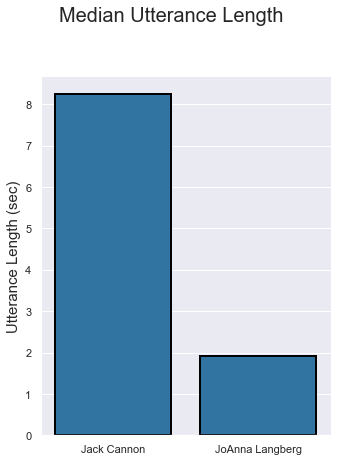

In [13]:
#cmap = {name: c for name, c in zip(ut_len.speaker.unique(), sns.color_palette('tab10'))}
g = sns.FacetGrid(data=ut_len, col='meeting_id', height=6, aspect=0.8, sharex=False, sharey=True)
g.map_dataframe(plot_ut, x='speaker', y='speak_time', color=sns.color_palette('tab10')[0], linewidth=2, edgecolor='black')
g.axes.flatten()[0].set_ylabel("Utterance Length (sec)", size=15)
g.axes.flatten()[0].set_xlabel("")
g.axes.flatten()[0].set_title("")
#g.fig.suptitle('Median Utterance Length by Meeting ID', size=20, y=1.1);
g.fig.suptitle('Median Utterance Length', size=20, y=1.1);

# Proportion Speaking Time

In [48]:
spk_time = df.loc[:, ['meeting_id', 'file', 'id', 'speak_time', 'speaker']] \
             .drop_duplicates(ignore_index=True) \
             .groupby(['meeting_id', 'file', 'speaker'], as_index=False) \
             .speak_time \
             .sum()
spk_time['meeting_time'] = spk_time.groupby('meeting_id', as_index=False) \
                                   .speak_time \
                                   .transform(sum)
spk_time['speak_pct'] = spk_time.speak_time / spk_time.meeting_time
spk_time

,meeting_id,file,speaker,speak_time,meeting_time,speak_pct
0,83512718053,GMT20210527-002121,Jack Cannon,2103.362,2190.722,0.960123
1,83512718053,GMT20210527-002121,JoAnna Langberg,87.360,2190.722,0.039877


In [49]:
def plot_donut(data, **kwargs):
    cmap = kwargs.pop('cmap')
    color = kwargs.pop('color')
    x = data[kwargs.pop('x')]
    labels = data[kwargs.pop('labels')]
    
    ax = plt.gca()
    ax.pie(x=x, labels=labels, colors=[cmap[name] for name in labels], **kwargs)
    ax.add_artist(plt.Circle((0, 0), 0.75, fc='white'))       

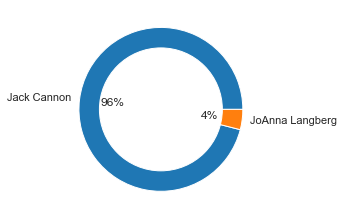

In [50]:
cmap = {name: c for name, c in zip(ut_len.speaker.unique(), sns.color_palette('tab10'))}
g = sns.FacetGrid(data=spk_time, col='meeting_id', height=6, aspect=0.8, despine=False)
g.map_dataframe(plot_donut, x='speak_time', labels='speaker', autopct="%0.f%%", cmap=cmap)
g.axes.flatten()[0].set_xlabel("")
g.axes.flatten()[0].set_title("")
#g.fig.suptitle('Speaking Proportion by Meeting ID', size=20, y=1);
#g.fig.suptitle('Proportion of Speaking Time', size=20, y=1);
plt.savefig("thesis/mscs_thesis/figures/3_1_1_pst.pdf", dpi=300, bbox_inches='tight')

# Window Analysis

In [70]:
windows = df.groupby(['meeting_id', 'file', 'speaker', 'window'], as_index=False) \
            .window_time \
            .sum()
windows

,meeting_id,file,speaker,window,window_time
0,83512718053,GMT20210527-002121,Jack Cannon,300,233.702
1,83512718053,GMT20210527-002121,Jack Cannon,600,239.460
2,83512718053,GMT20210527-002121,Jack Cannon,900,254.670
3,83512718053,GMT20210527-002121,Jack Cannon,1200,251.620
4,83512718053,GMT20210527-002121,Jack Cannon,1500,254.130
5,83512718053,GMT20210527-002121,Jack Cannon,1800,249.150
6,83512718053,GMT20210527-002121,Jack Cannon,2100,262.120
7,83512718053,GMT20210527-002121,Jack Cannon,2400,269.740
8,83512718053,GMT20210527-002121,Jack Cannon,2700,81.770
9,83512718053,GMT20210527-002121,JoAnna Langberg,300,3.720


In [71]:
def plot_windows(data, **kwargs):
    cmap = kwargs.pop('cmap')
    color = kwargs.pop('color')
    width = kwargs.pop('width')
    ax = plt.gca()
    windows = data.window.unique()
    x_labs = np.arange(windows.size)
    last = pd.Series([0] * windows.size, index=windows)
    for grp, d in data.groupby('speaker'):
        window = d.window
        window_time = d.window_time
        if d.window.size != len(x_labs):
            window_time = pd.Series(window_time.tolist(), index=d.window).reindex(windows, fill_value=0)
            window = window_time.index.to_numpy()
        ax.bar(x_labs, window_time, width, bottom=last, label=grp, color=cmap[grp], **kwargs)
        last = last + pd.Series(window_time.to_numpy(), index=window)
        last.fillna(0, inplace=True)
    ax.set_xticks(x_labs)
    ax.set_xticklabels(data.window.unique())

/Users/jackcan/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


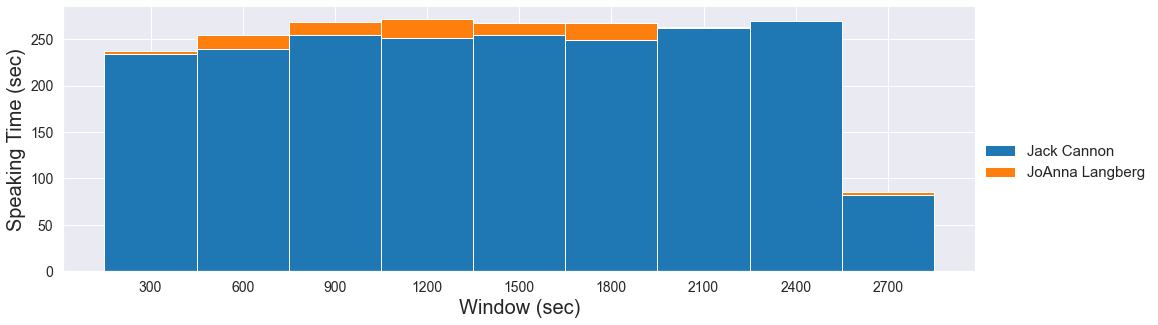

In [72]:
g = sns.FacetGrid(data=windows, col='meeting_id', height=4.5, aspect=3, sharex=False, sharey=False)
g.map_dataframe(plot_windows, cmap=cmap, width=1)
g.add_legend(adjust_subtitles=True, fontsize=15)
#g.axes[0].set_ylabel('Speaking Time', size=15)
g.axes[0][0].set_title('')
g.axes[0][0].set_ylabel('Speaking Time (sec)', size=20)
g.axes[0][0].set_xlabel('Window (sec)', size=20)
g.axes[0][0].set_xticklabels(g.axes[0][0].get_xticklabels(), size=14)
g.axes[0][0].set_yticklabels(g.axes[0][0].get_yticklabels(), size=14);
#g.fig.suptitle('Speaking Pace over Time by Meeting ID', size=30, y=1.1);

# Sentiment Analysis

### Prep Model

In [19]:
candidate_labels = ['POSITIVE', 'NEUTRAL', 'NEGATIVE']
clf = partial(pipeline("zero-shot-classification", model='typeform/distilbert-base-uncased-mnli'), 
              candidate_labels=candidate_labels)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [20]:
def parse_zshot(clf, sequences):      
    results = clf(sequences)
    if not isinstance(results, list):
        results = [results]
    
    out = []
    for i, r in enumerate(results):
        for l, s in zip(r['labels'], r['scores']):
            out.append({'idx': i, 'seq': r['sequence'], 'granularity': 'binary', 'label': l, 'score': s})
        
    return out

In [21]:
sequences = df.text.to_list()

In [22]:
data = parse_zshot(clf, sequences)
sentiment_df = pd.DataFrame(data)

In [23]:
sentiment_df

,idx,seq,granularity,label,score
0,0,Here we go.,binary,POSITIVE,0.461708
1,0,Here we go.,binary,NEGATIVE,0.384784
2,0,Here we go.,binary,NEUTRAL,0.153508
3,1,One second.,binary,NEGATIVE,0.381538
4,1,One second.,binary,POSITIVE,0.345879
...,...,...,...,...,...
874,291,or stop recording.,binary,POSITIVE,0.334242
875,291,or stop recording.,binary,NEUTRAL,0.297251
876,292,Start recording it was just testing you.,binary,NEGATIVE,0.519143
877,292,Start recording it was just testing you.,binary,POSITIVE,0.372827


In [24]:
sentiment_df2 = sentiment_df.sort_values(['idx', 'score'], ascending=[True, False]) \
                            .drop_duplicates(subset='idx', keep='first') \
                            .set_index('idx')

In [25]:
sentiment_df2

,seq,granularity,label,score
idx,,,,
0,Here we go.,binary,POSITIVE,0.461708
1,One second.,binary,NEGATIVE,0.381538
2,"When I did my presentation, the other day.",binary,POSITIVE,0.401223
3,I got to hit the share button.,binary,POSITIVE,0.659739
4,it's like you click share and then your monit...,binary,POSITIVE,0.475190
...,...,...,...,...
288,lot of material.,binary,NEGATIVE,0.451246
289,For this next data set.,binary,POSITIVE,0.571632
290,So i'm going to stop sharing.,binary,NEGATIVE,0.949988


In [26]:
data = df[['meeting_id', 'speaker', 'speak_time', 'num_words']].join(sentiment_df2[['label', 'score']])
data['sentiment_pct'] = data.speak_time / data.groupby('speaker').speak_time.transform(sum)
data

,meeting_id,speaker,speak_time,num_words,label,score,sentiment_pct
0,83512718053,Jack Cannon,0.631,3,POSITIVE,0.461708,0.000290
1,83512718053,Jack Cannon,0.600,2,NEGATIVE,0.381538,0.000276
2,83512718053,Jack Cannon,3.030,8,POSITIVE,0.401223,0.001394
3,83512718053,Jack Cannon,2.491,7,POSITIVE,0.659739,0.001146
4,83512718053,Jack Cannon,2.910,11,POSITIVE,0.475190,0.001338
...,...,...,...,...,...,...,...
288,83512718053,Jack Cannon,1.350,3,NEGATIVE,0.451246,0.000621
289,83512718053,Jack Cannon,1.350,5,POSITIVE,0.571632,0.000621
290,83512718053,Jack Cannon,1.470,6,NEGATIVE,0.949988,0.000676
291,83512718053,JoAnna Langberg,0.870,3,NEGATIVE,0.368508,0.009959


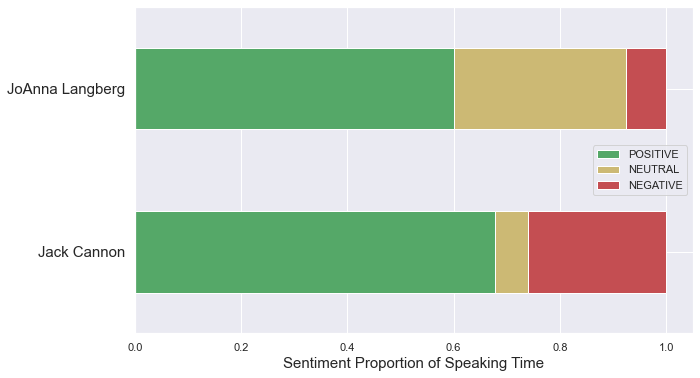

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
data.groupby(['speaker', 'label'], as_index=False) \
    .sentiment_pct \
    .sum() \
    .pivot(index=['speaker'], columns='label', values='sentiment_pct') \
    .reindex(columns=['POSITIVE', 'NEUTRAL', 'NEGATIVE']) \
    .plot \
    .barh(stacked=True,
          ax=ax,
          color={'POSITIVE': 'g', 'NEGATIVE': 'r', 'NEUTRAL': 'y'}, 
          legend=False)
ax.set_ylabel("")
ax.set_xlabel("Sentiment Proportion of Speaking Time", size=15)
ax.set_yticklabels(ax.get_yticklabels(), size=15)
ax.legend()
handles, labels = ax.get_legend_handles_labels()
plt.savefig()
#fig.legend(handles, labels, ncol=3, loc='upper center');
#fig.legend(handles, labels, ncol=1, loc='best');

In [28]:
data.groupby(['speaker', 'label'], as_index=False) \
    .sentiment_pct \
    .sum() \
    .pivot(index=['speaker'], columns='label', values='sentiment_pct') \
    .reindex(columns=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

label,POSITIVE,NEUTRAL,NEGATIVE
speaker,,,
Jack Cannon,0.677328,0.063086,0.259586
JoAnna Langberg,0.600618,0.323832,0.075549


# Zoom Group Stats

In [51]:
zgsent_df = pd.read_csv('zoomGroupStats/sentiment_data_aws.csv') \
               .query("userName != 'UNIDENTIFIED'")
zgsent_df.rename(columns={
        'batchMeetingId': 'meeting_id',
        'utteranceId': 'id',
        'userName': 'speaker',
        'utteranceTimeWindow': 'speak_time',
        'aws_sentClass': 'label'
    }, 
                 inplace=True)
zgsent_df.head()

,Unnamed: 0,meeting_id,id,speaker,utteranceStartSeconds,utteranceStartTime,utteranceEndSeconds,utteranceEndTime,speak_time,utteranceMessage,utteranceLanguage,label,aws_positive,aws_negative,aws_neutral,aws_mixed
0,1,83512718053,1,Jack Cannon,0.299,2021-05-26 17:16:33,0.93,2021-05-26 17:16:33,0.631,Here we go.,en,NEUTRAL,0.108605,0.012051,0.876525,0.002819
1,2,83512718053,2,Jack Cannon,9.690,2021-05-26 17:16:42,10.29,2021-05-26 17:16:43,0.600,One second.,en,NEUTRAL,0.017958,0.019770,0.953635,0.008637
2,3,83512718053,3,Jack Cannon,13.320,2021-05-26 17:16:46,16.35,2021-05-26 17:16:49,3.030,"When I did my presentation, the other day.",en,NEUTRAL,0.032612,0.015213,0.951968,0.000207
3,4,83512718053,4,Jack Cannon,17.789,2021-05-26 17:16:50,20.28,2021-05-26 17:16:53,2.491,I got to hit the share button.,en,NEUTRAL,0.185420,0.070934,0.731618,0.012028
4,5,83512718053,5,Jack Cannon,22.080,2021-05-26 17:16:55,24.99,2021-05-26 17:16:57,2.910,it's like you click share and then your monito...,en,NEUTRAL,0.143859,0.347923,0.485936,0.022283


In [52]:
zgpst_df = pd.read_csv('zoomGroupStats/convoTrans_speaker_level.csv') \
             .query("userName != 'UNIDENTIFIED'")
zgpst_df.rename(columns={
        'batchMeetingId': 'meeting_id',
        'userName': 'speaker',
        'utteranceTimeWindow_sum': 'speak_time'
    }, 
                 inplace=True)
zgpst_df.head()

,Unnamed: 0,meeting_id,speaker,firstUtteranceTime,lastUtteranceTime,speak_time,utteranceTimeWindow_x,utteranceTimeWindow_sd,utteranceGap_x,utteranceGap_sd,numUtterances
0,1,83512718053,Jack Cannon,2021-05-26 17:16:33,2021-05-26 17:58:47,2103.362002,8.121089,8.121089,1.154066,0.955121,259
1,2,83512718053,JoAnna Langberg,2021-05-26 17:17:00,2021-05-26 17:58:46,87.360000,3.494400,3.494400,1.867200,4.615885,25


In [53]:
zgwin_df = pd.read_csv('zoomGroupStats/winConvo_speaker_level.csv') \
             .query("userName != 'UNIDENTIFIED'")
zgwin_df.rename(columns={
        'batchMeetingId': 'meeting_id',
        'userName': 'speaker',
        'utteranceTimeWindow_sum': 'window_time'
    }, 
                 inplace=True)
zgwin_df['window'] = zgwin_df.windowEnd + 1
zgwin_df.head()

,Unnamed: 0,meeting_id,speaker,windowId,windowStart,windowEnd,firstUtteranceTime,lastUtteranceTime,window_time,utteranceTimeWindow_x,utteranceTimeWindow_sd,utteranceGap_x,utteranceGap_sd,numUtterances,window
0,1,83512718053,Jack Cannon,1,0,299,2021-05-26 17:16:33,2021-05-26 17:21:20,233.702000,5.992359,5.992359,1.543395,1.558359,39,300
1,2,83512718053,Jack Cannon,2,300,599,2021-05-26 17:21:35,2021-05-26 17:26:26,243.300000,7.848387,7.848387,1.298000,0.929113,31,600
2,3,83512718053,Jack Cannon,3,600,899,2021-05-26 17:26:37,2021-05-26 17:31:28,255.390000,7.980938,7.980938,0.945484,0.551373,32,900
3,4,83512718053,Jack Cannon,4,900,1199,2021-05-26 17:31:36,2021-05-26 17:36:23,253.290001,8.734138,8.734138,0.826071,0.677322,29,1200
4,5,83512718053,Jack Cannon,5,1200,1499,2021-05-26 17:36:37,2021-05-26 17:41:31,261.030001,8.420323,8.420323,0.983000,0.795705,31,1500


## Average Utterance Length

In [54]:
zg_utlen = zgsent_df.loc[:, ['meeting_id', 'id', 'speaker', 'speak_time']] \
           .drop_duplicates(ignore_index=True) \
           .groupby(['meeting_id', 'speaker'], as_index=False) \
           .speak_time \
           .median() \
           .sort_values(['meeting_id', 'speak_time'], ascending=False, ignore_index=True)
zg_utlen['tool'] = 'zoomGroupStats'
zg_utlen

,meeting_id,speaker,speak_time,tool
0,83512718053,Jack Cannon,8.25,zoomGroupStats
1,83512718053,JoAnna Langberg,1.92,zoomGroupStats


In [55]:
ut_len['tool'] = 'Python'

In [56]:
comb_utlen = pd.concat([ut_len, zg_utlen], ignore_index=True)
comb_utlen

,meeting_id,speaker,speak_time,tool
0,83512718053,Jack Cannon,8.25,Python
1,83512718053,JoAnna Langberg,1.92,Python
2,83512718053,Jack Cannon,8.25,zoomGroupStats
3,83512718053,JoAnna Langberg,1.92,zoomGroupStats


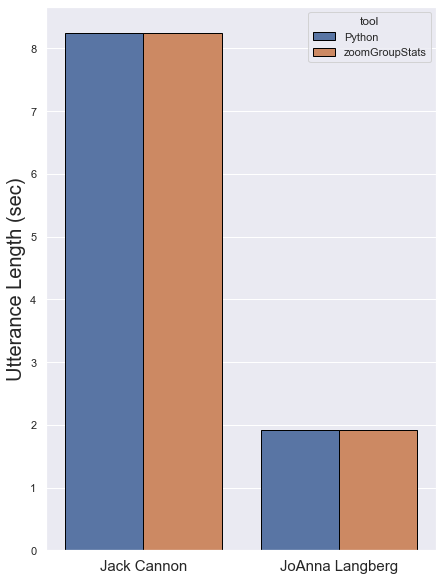

In [57]:
fig = plt.figure(figsize=(7, 10))
ax = fig.gca()
sns.barplot(x='speaker', y='speak_time', hue='tool', data=comb_utlen, linewidth=1, edgecolor='black', ax=ax)
ax.set_ylabel("Utterance Length (sec)", size=20)
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), size=15)
plt.savefig("thesis/mscs_thesis/figures/3_1_1_zgs_cmp_aul.pdf", dpi=300, bbox_inches='tight')

In [58]:
comb_utlen

,meeting_id,speaker,speak_time,tool
0,83512718053,Jack Cannon,8.25,Python
1,83512718053,JoAnna Langberg,1.92,Python
2,83512718053,Jack Cannon,8.25,zoomGroupStats
3,83512718053,JoAnna Langberg,1.92,zoomGroupStats


## Proportion Speaking Time

In [59]:
spk_time = zgpst_df.loc[:, ['meeting_id', 'speak_time', 'speaker']] \
                 .drop_duplicates(ignore_index=True) \
                 .groupby(['meeting_id', 'speaker'], as_index=False) \
                 .speak_time \
                 .sum()
spk_time['meeting_time'] = spk_time.groupby('meeting_id', as_index=False) \
                                   .speak_time \
                                   .transform(sum)
spk_time['speak_pct'] = spk_time.speak_time / spk_time.meeting_time
spk_time

,meeting_id,speaker,speak_time,meeting_time,speak_pct
0,83512718053,Jack Cannon,2103.362002,2190.722003,0.960123
1,83512718053,JoAnna Langberg,87.360000,2190.722003,0.039877


In [60]:
spk_time

,meeting_id,speaker,speak_time,meeting_time,speak_pct
0,83512718053,Jack Cannon,2103.362002,2190.722003,0.960123
1,83512718053,JoAnna Langberg,87.360000,2190.722003,0.039877


In [61]:
def plot_donut(data, **kwargs):
    cmap = kwargs.pop('cmap')
    color = kwargs.pop('color')
    x = data[kwargs.pop('x')]
    labels = data[kwargs.pop('labels')]
    
    ax = plt.gca()
    ax.pie(x=x, labels=labels, colors=[cmap[name] for name in labels], **kwargs)
    ax.add_artist(plt.Circle((0, 0), 0.75, fc='white'))       

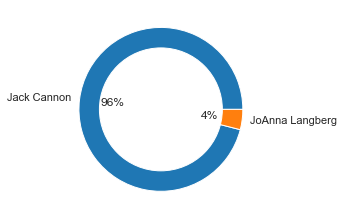

In [62]:
cmap = {name: c for name, c in zip(ut_len.speaker.unique(), sns.color_palette('tab10'))}
g = sns.FacetGrid(data=spk_time, col='meeting_id', height=6, aspect=0.8, despine=False)
g.map_dataframe(plot_donut, x='speak_time', labels='speaker', autopct="%0.f%%", cmap=cmap)
g.axes.flatten()[0].set_xlabel("")
g.axes.flatten()[0].set_title("")
#g.fig.suptitle('Speaking Proportion by Meeting ID', size=20, y=1);
#g.fig.suptitle('Proportion of Speaking Time', size=20, y=1);
plt.savefig("thesis/mscs_thesis/figures/3_1_1_zgs_pst.pdf", dpi=300, bbox_inches='tight')

## Window Analysis

In [73]:
zgwin_df.head()

,Unnamed: 0,meeting_id,speaker,windowId,windowStart,windowEnd,firstUtteranceTime,lastUtteranceTime,window_time,utteranceTimeWindow_x,utteranceTimeWindow_sd,utteranceGap_x,utteranceGap_sd,numUtterances,window
0,1,83512718053,Jack Cannon,1,0,299,2021-05-26 17:16:33,2021-05-26 17:21:20,233.702000,5.992359,5.992359,1.543395,1.558359,39,300
1,2,83512718053,Jack Cannon,2,300,599,2021-05-26 17:21:35,2021-05-26 17:26:26,243.300000,7.848387,7.848387,1.298000,0.929113,31,600
2,3,83512718053,Jack Cannon,3,600,899,2021-05-26 17:26:37,2021-05-26 17:31:28,255.390000,7.980938,7.980938,0.945484,0.551373,32,900
3,4,83512718053,Jack Cannon,4,900,1199,2021-05-26 17:31:36,2021-05-26 17:36:23,253.290001,8.734138,8.734138,0.826071,0.677322,29,1200
4,5,83512718053,Jack Cannon,5,1200,1499,2021-05-26 17:36:37,2021-05-26 17:41:31,261.030001,8.420323,8.420323,0.983000,0.795705,31,1500


In [74]:
def plot_windows(data, **kwargs):
    cmap = kwargs.pop('cmap')
    color = kwargs.pop('color')
    width = kwargs.pop('width')
    ax = plt.gca()
    windows = data.window.unique()
    x_labs = np.arange(windows.size)
    last = pd.Series([0] * windows.size, index=windows)
    for grp, d in data.groupby('speaker'):
        window = d.window
        window_time = d.window_time
        if d.window.size != len(x_labs):
            window_time = pd.Series(window_time.tolist(), index=d.window).reindex(windows, fill_value=0)
            window = window_time.index.to_numpy()
        ax.bar(x_labs, window_time, width, bottom=last, label=grp, color=cmap[grp], **kwargs)
        last = last + pd.Series(window_time.to_numpy(), index=window)
        last.fillna(0, inplace=True)
    ax.set_xticks(x_labs)
    ax.set_xticklabels(data.window.unique())

/Users/jackcan/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


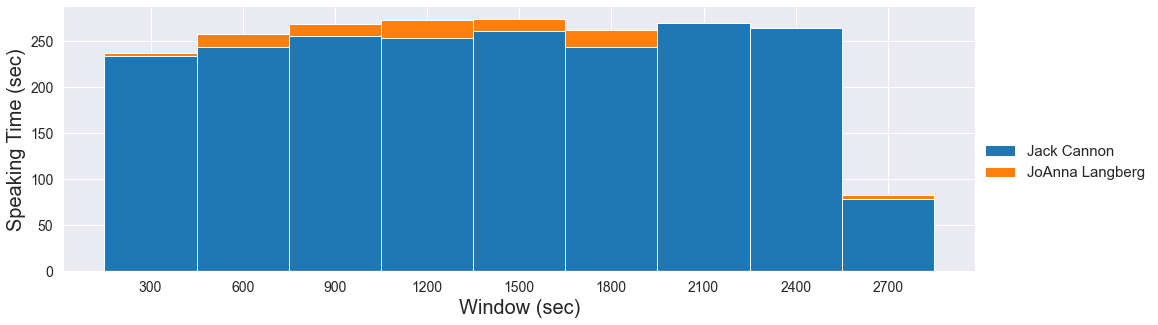

In [79]:
g = sns.FacetGrid(data=zgwin_df, col='meeting_id', height=4.5, aspect=3, sharex=False, sharey=False)
g.map_dataframe(plot_windows, cmap=cmap, width=1)
g.add_legend(adjust_subtitles=True, fontsize=15)
#g.axes[0].set_ylabel('Speaking Time', size=15)
g.axes[0][0].set_title('')
g.axes[0][0].set_ylabel('Speaking Time (sec)', size=20)
g.axes[0][0].set_xlabel('Window (sec)', size=20)
g.axes[0][0].set_xticklabels(g.axes[0][0].get_xticklabels(), size=14)
g.axes[0][0].set_yticklabels(g.axes[0][0].get_yticklabels(), size=14);
plt.savefig("thesis/mscs_thesis/figures/3_1_1_zgs_spt.pdf", dpi=300, bbox_inches='tight')
#g.fig.suptitle('Speaking Pace over Time by Meeting ID', size=30, y=1.1);

My plot

In [76]:
win_diff = zgwin_df[['meeting_id', 'speaker', 'window', 'window_time']].merge(windows[['meeting_id', 'speaker', 'window', 'window_time']],
                                                                              how='left',
                                                                              on=['meeting_id', 'speaker', 'window'])
win_diff

,meeting_id,speaker,window,window_time_x,window_time_y
0,83512718053,Jack Cannon,300,233.702000,233.702
1,83512718053,Jack Cannon,600,243.300000,239.460
2,83512718053,Jack Cannon,900,255.390000,254.670
3,83512718053,Jack Cannon,1200,253.290001,251.620
4,83512718053,Jack Cannon,1500,261.030001,254.130
5,83512718053,Jack Cannon,1800,243.570000,249.150
6,83512718053,Jack Cannon,2100,269.280000,262.120
7,83512718053,Jack Cannon,2400,264.840001,269.740
8,83512718053,Jack Cannon,2700,78.960000,81.770
9,83512718053,JoAnna Langberg,300,3.720000,3.720


In [77]:
(win_diff.window_time_x - win_diff.window_time_y).mean()

0.4117648533091258

/Users/jackcan/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


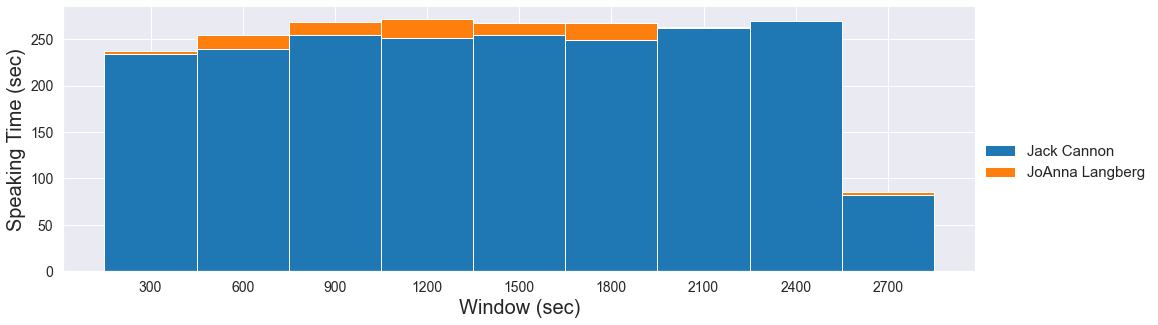

In [80]:
g = sns.FacetGrid(data=windows, col='meeting_id', height=4.5, aspect=3, sharex=False, sharey=False)
g.map_dataframe(plot_windows, cmap=cmap, width=1)
g.add_legend(adjust_subtitles=True, fontsize=15)
#g.axes[0].set_ylabel('Speaking Time', size=15)
g.axes[0][0].set_title('')
g.axes[0][0].set_ylabel('Speaking Time (sec)', size=20)
g.axes[0][0].set_xlabel('Window (sec)', size=20)
g.axes[0][0].set_xticklabels(g.axes[0][0].get_xticklabels(), size=14)
g.axes[0][0].set_yticklabels(g.axes[0][0].get_yticklabels(), size=14)
plt.savefig("thesis/mscs_thesis/figures/3_1_1_spt.pdf", dpi=300, bbox_inches='tight')
#g.fig.suptitle('Speaking Pace over Time by Meeting ID', size=30, y=1.1);

## Sentiment Analysis

In [81]:
zgsent_df['sentiment_pct'] = zgsent_df.speak_time / zgsent_df.groupby('speaker').speak_time.transform(sum)

In [82]:
zgsent_df.head()

,Unnamed: 0,meeting_id,id,speaker,utteranceStartSeconds,utteranceStartTime,utteranceEndSeconds,utteranceEndTime,speak_time,utteranceMessage,utteranceLanguage,label,aws_positive,aws_negative,aws_neutral,aws_mixed,sentiment_pct
0,1,83512718053,1,Jack Cannon,0.299,2021-05-26 17:16:33,0.93,2021-05-26 17:16:33,0.631,Here we go.,en,NEUTRAL,0.108605,0.012051,0.876525,0.002819,0.000300
1,2,83512718053,2,Jack Cannon,9.690,2021-05-26 17:16:42,10.29,2021-05-26 17:16:43,0.600,One second.,en,NEUTRAL,0.017958,0.019770,0.953635,0.008637,0.000285
2,3,83512718053,3,Jack Cannon,13.320,2021-05-26 17:16:46,16.35,2021-05-26 17:16:49,3.030,"When I did my presentation, the other day.",en,NEUTRAL,0.032612,0.015213,0.951968,0.000207,0.001441
3,4,83512718053,4,Jack Cannon,17.789,2021-05-26 17:16:50,20.28,2021-05-26 17:16:53,2.491,I got to hit the share button.,en,NEUTRAL,0.185420,0.070934,0.731618,0.012028,0.001184
4,5,83512718053,5,Jack Cannon,22.080,2021-05-26 17:16:55,24.99,2021-05-26 17:16:57,2.910,it's like you click share and then your monito...,en,NEUTRAL,0.143859,0.347923,0.485936,0.022283,0.001383


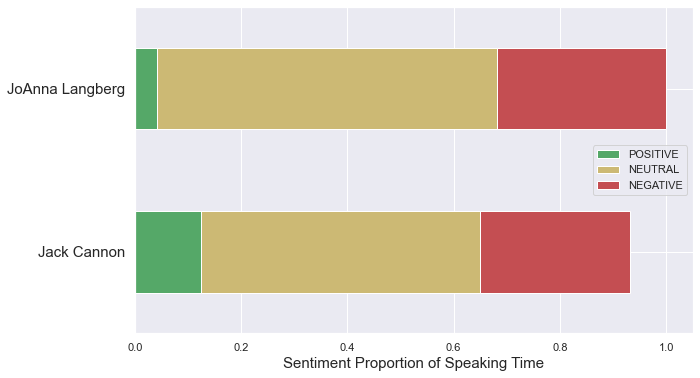

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
zgsent_df.groupby(['speaker', 'label'], as_index=False) \
        .sentiment_pct \
        .sum() \
        .pivot(index=['speaker'], columns='label', values='sentiment_pct') \
        .reindex(columns=['POSITIVE', 'NEUTRAL', 'NEGATIVE']) \
        .plot \
        .barh(stacked=True,
              ax=ax,
              color={'POSITIVE': 'g', 'NEGATIVE': 'r', 'NEUTRAL': 'y'}, 
              legend=False)
ax.set_ylabel("")
ax.set_xlabel("Sentiment Proportion of Speaking Time", size=15)
ax.set_yticklabels(ax.get_yticklabels(), size=15)
ax.legend()
handles, labels = ax.get_legend_handles_labels()
plt.savefig("thesis/mscs_thesis/figures/3_1_1_zgs_sol.pdf", dpi=300, bbox_inches='tight')
#fig.legend(handles, labels, ncol=3, loc='upper center');
#fig.legend(handles, labels, ncol=1, loc='best');

My plot

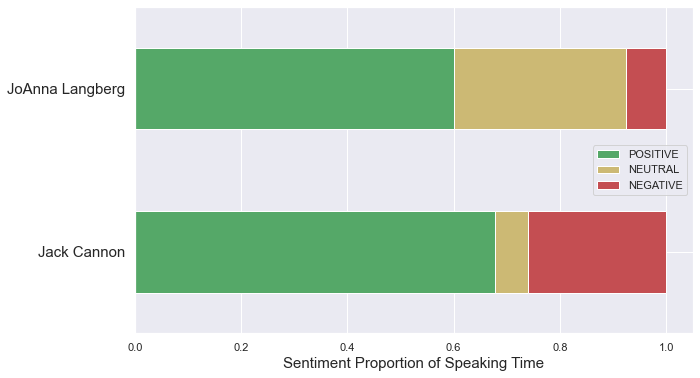

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
data.groupby(['speaker', 'label'], as_index=False) \
    .sentiment_pct \
    .sum() \
    .pivot(index=['speaker'], columns='label', values='sentiment_pct') \
    .reindex(columns=['POSITIVE', 'NEUTRAL', 'NEGATIVE']) \
    .plot \
    .barh(stacked=True,
          ax=ax,
          color={'POSITIVE': 'g', 'NEGATIVE': 'r', 'NEUTRAL': 'y'}, 
          legend=False)
ax.set_ylabel("")
ax.set_xlabel("Sentiment Proportion of Speaking Time", size=15)
ax.set_yticklabels(ax.get_yticklabels(), size=15)
ax.legend()
handles, labels = ax.get_legend_handles_labels()
plt.savefig("thesis/mscs_thesis/figures/3_1_1_sol.pdf", dpi=300, bbox_inches='tight')
#fig.legend(handles, labels, ncol=3, loc='upper center');
#fig.legend(handles, labels, ncol=1, loc='best');